In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
#To write a Python 2/3 compatible codebase

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
import pathlib 
#Pathlib provides a more readable and easier way to build up paths by representing filesystem paths as proper objects and enables us to write code that is portable across platforms.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
#ploting graphs

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [7]:
tf.__version__

'2.3.0'

In [8]:
#Train and test data folder

train_data_dir = "/content/drive/MyDrive/kvasir-dataset"
test_data_dir = "/content/drive/MyDrive/kvasir-dataset/dyed-resection-margins"

In [9]:
train_data_dir = pathlib.Path(train_data_dir)
test_data_dir = pathlib.Path(test_data_dir)

In [10]:
#count how many images are there
image_count = len(list(train_data_dir.glob('*/*.jpg')))
image_count

4032

In [11]:
total_train = len(list(train_data_dir.glob('*/*.jpg')))
total_val = len(list(test_data_dir.glob('*/*.jpg')))

In [12]:
#get the class names
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['ulcerative-colitis', 'esophagitis', 'normal-pylorus',
       'dyed-resection-margins', 'normal-z-line', 'normal-cecum',
       'polyps', 'dyed-lifted-polyps'], dtype='<U22')

In [13]:
#Define parameter for training
batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/batch_size)
epochs = 8
num_classes = len(CLASS_NAMES) #23

In [14]:
#We use image data generators to load the images and prepare them for the training

train_image_generator = ImageDataGenerator() # Generator for our training data
validation_image_generator = ImageDataGenerator() # Generator for our validation data


train_data_gen = train_image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode='categorical'
                                                          )

val_data_gen = validation_image_generator.flow_from_directory(directory=str(test_data_dir),
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                     classes = list(CLASS_NAMES)
                                                             )
#get class order from directories
print(train_data_gen.class_indices.keys())
print(val_data_gen.class_indices.keys())


Found 4032 images belonging to 8 classes.
Found 0 images belonging to 8 classes.
dict_keys(['ulcerative-colitis', 'esophagitis', 'normal-pylorus', 'dyed-resection-margins', 'normal-z-line', 'normal-cecum', 'polyps', 'dyed-lifted-polyps'])
dict_keys(['ulcerative-colitis', 'esophagitis', 'normal-pylorus', 'dyed-resection-margins', 'normal-z-line', 'normal-cecum', 'polyps', 'dyed-lifted-polyps'])


In [15]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# base model from the pre-trained model. Resnet 50 in this case
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

94773248/94765736 [==============================] - 0s 0us/step


In [16]:
#add new classification layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(num_classes,activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
#fit the model
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/8
126/126 [==============================] - 1125s 9s/step - loss: 0.7003 - accuracy: 0.7485
Epoch 2/8
126/126 [==============================] - 639s 5s/step - loss: 0.3502 - accuracy: 0.8728
Epoch 3/8
126/126 [==============================] - 639s 5s/step - loss: 0.2856 - accuracy: 0.8973
Epoch 4/8
126/126 [==============================] - 638s 5s/step - loss: 0.2532 - accuracy: 0.9060
Epoch 5/8
126/126 [==============================] - 638s 5s/step - loss: 0.2239 - accuracy: 0.9224
Epoch 6/8
126/126 [==============================] - 639s 5s/step - loss: 0.2038 - accuracy: 0.9298
Epoch 7/8
126/126 [==============================] - 639s 5s/step - loss: 0.1732 - accuracy: 0.9392
Epoch 8/8
126/126 [==============================] - 640s 5s/step - loss: 0.1689 - accuracy: 0.9439


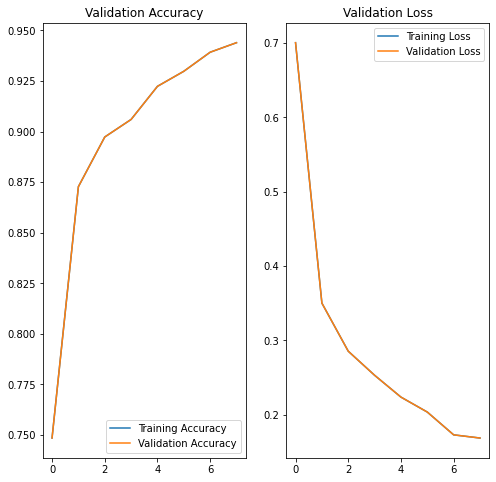

In [20]:
#create training plots
history
acc = history.history['accuracy']
val_acc = history.history['accuracy']

loss = history.history['loss']
val_loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()

In [21]:
base_model.trainable = True #now we want to train the base model

In [22]:
# How many layers are in the base model
print("Layers base model: ", len(base_model.layers))

# Fine tune from layer x
fine_tune_at = 100

# Freeze all the layers before the fine tune starting layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Layers base model:  175


In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [24]:
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [25]:
#Fine tune step
initial_epochs = 7
fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs
train_batches = total_train // batch_size
print(total_val // batch_size)
validation_batches = total_val // batch_size

history_fine = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=total_epochs,
    initial_epoch = history.epoch[-1],
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

0
Epoch 8/10
126/126 [==============================] - 1436s 11s/step - loss: 0.3448 - accuracy: 0.8802
Epoch 9/10
126/126 [==============================] - 1442s 11s/step - loss: 0.1054 - accuracy: 0.9638
Epoch 10/10
126/126 [==============================] - 1427s 11s/step - loss: 0.0555 - accuracy: 0.9812


In [26]:
acc += history_fine.history['accuracy']
#val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
#val_loss += history_fine.history['val_loss']

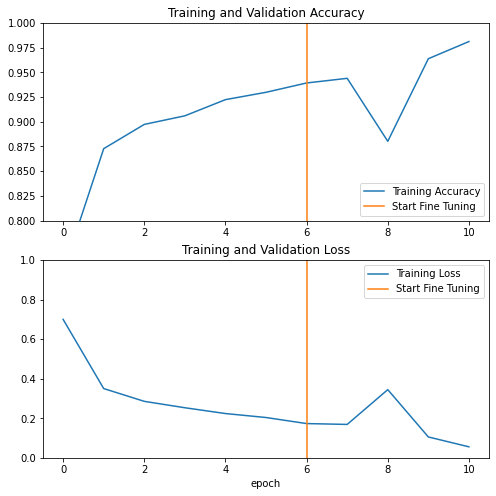

In [27]:
#Plot fine tuning 
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
#model save and load
import os

In [29]:
#some time stamp 
from datetime import datetime
# current date and time.
now = datetime.now()
timestamp = datetime.timestamp(now)
print("timestamp =", timestamp)

timestamp = 1608015070.715345


In [30]:
model_filename = str(timestamp)+'mymodel.h5'
model.save(model_filename)

In [31]:
#To apply the model on new data
new_model = tf.keras.models.load_model(model_filename)

# Show the model architecture
new_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [32]:
from tensorflow.keras.preprocessing import image

#image directory containing images to test
img_dir="/content/drive/MyDrive/test_data"

for i,img in enumerate(os.listdir(img_dir)):
  tmpimage = image.load_img(os.path.join(img_dir,img), target_size=(IMG_SIZE,IMG_SIZE))   
  tmpimage = np.expand_dims(tmpimage, axis=0).astype('float32')    
  result_class=new_model.predict(tmpimage)
  print(img,";",CLASS_NAMES[result_class.argmax(axis=-1)])

pylorus1.jpg ; ['normal-pylorus']
pylorus2.jpg ; ['esophagitis']
pylorus3.jpg ; ['normal-pylorus']
pylorus4.jpg ; ['ulcerative-colitis']
pylorus5.jpg ; ['esophagitis']
pylorus6.jpg ; ['ulcerative-colitis']
pylorus7.jpg ; ['ulcerative-colitis']
pylorus8.jpg ; ['ulcerative-colitis']
pylorus9.jpg ; ['esophagitis']
pylorus10.jpg ; ['ulcerative-colitis']
esophagitis1.jpg ; ['esophagitis']
esophagitis2.jpg ; ['esophagitis']
esophagitis3.jpg ; ['normal-z-line']
esophagitis4.jpg ; ['esophagitis']
esophagitis5.jpg ; ['normal-z-line']
esophagitis6.jpg ; ['esophagitis']
esophagitis7.jpg ; ['esophagitis']
esophagitis8.jpg ; ['esophagitis']
esophagitis9.jpg ; ['esophagitis']
esophagitis10.jpg ; ['esophagitis']
ulcerative-colitis1.jpg ; ['esophagitis']
ulcerative-colitis2.jpg ; ['ulcerative-colitis']
ulcerative-colitis3.jpg ; ['dyed-lifted-polyps']
ulcerative-colitis4.jpg ; ['ulcerative-colitis']
ulcerative-colitis5.jpg ; ['ulcerative-colitis']
ulcerative-colitis6.jpg ; ['ulcerative-colitis']
ulcera

In [ ]:
!pip install argparse